In [1]:
using Optim, LsqFit
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles
using Statistics
using DataFrames
using BenchmarkTools

In [2]:
pyplot(grid=:off)

Plots.PyPlotBackend()

In [3]:
ENV["COLUMNS"]=120
figdir = "figures/";

# Viral load data fitting

The purpose of this notebook is to study the how to fit the viral load function to data. This notebook is splitted in 3 parts.

 1. Virus load function and empirical virus Load Function definitions.
 2. Data set.
 3. Optimization methods test.
 4. Effect of trailling threshold values.
 5. Changing the value of fixed $V_{min}$
 6. Empirical versus non-empirical Virus Load Function.
 7. Radomized initial estimate 

## 1. Standard virus load function

Consider a virus load function with three main phases given by

$$V(t; p)=v_1(t; a_1, a_2, V_{\max})v_2(t; a_2, \alpha)v_3(t; b_1, b_2, V_{\min}),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t; a_1, a_2, V_{\max}) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t; a_2, \alpha) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t; b_1, b_2, V_{\min}) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function, and $p=(a_1, a_2, b_1, b_2, \alpha, V_{\min}, V_{\max})^t$ is the vector of parameters. There are non-nengativity $a_1, a_2, b_1, b_2, \alpha, V_{\min}, V_{\max} >0$, and ordering $0<a_1<a_2<b_1<b_2$ conditions.

### Chanlenges fitting the virus load function

- The parameter $V_{\min}$ is particularly difficult to deal with because is smaller than reasonable steps length, causing $v_3(t)$ to become negative.

  Solutions to this problem:

  - Rescale $V_{\min}$, i.e., $V_{\min} = 10^{\tilde V_{\min}}$. **Implemented here.**
  - Fix the value of $V_{\min}$.  **Implemented and studied here.**
  - Restrict the step length, but convergence would take much longer. This could be done via `LineSearches.jl`.

- A similar issue occurs with $V_{\max}$, the scale is this parameter is very large compared to the rest.
  
  Solutions to this problem:
  
  - Rescale $V_{\max}$, i.e., $V_{\max} = 10^{\tilde V_{\min}}$. **Implemented here.**
  - Include weights. This could be done via `LsqFit.jl`

- The initial guess and lower and upper bounds are tricky to choose. First, because we could have violation of the ordering condition during optimation; and second, if we impose bounds forcing this condition it is easy to hit the bounds when optimizing.

  Solutions to this problem: 

  - Inspect graphically the data to provide an eye-picked initial parameters estimates.
  - Alternatively, we can choose a random selection of initial parameters values and discard best estimates that violate ordering and non-negativity conditions.
  - Use optimization with bounds.
  - Use $|a_2-a_1|$ and $|b_2-b_1|$ in $v_1(t)$ and $v_3(t)$ to avoid error when evaluating the function.

- Standard error are sometime large.

- Data usually has a threshold of beloe which all counts are given the same value. For example, points equal to $0$ from time $t=8$ to $t=12$ in the sata set above.

- The heaviside funnction is discontinous, which causes troubles with some computational routines, such as, automatic differenciation, and forward differenciation. To overcome this limitation we use the hyperbolic tangent as continous approximation for the Heaviside function

  $$
  H(t) \approx \frac{1}{2}(\tanh(c t)+1),
  $$
  where $c$ is a large number (e.g., $c=10^3$).

**Using the rescaling $V_{\min}$ and $V_{\max}$ seems to be the better solution for the first three problems above.**

### Empirical virus load function

**We are forcing the function to be equal to a threshold $\theta$ when the value of the function drops below that value. For that we define the empirical virus load function.**

$$
\hat V_{\theta}(t) = \max( \log V(t), \theta).
$$

In [4]:
# H(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
H(x) = 0.5*(tanh(1e3*x) + 1.)
function v₁(t, a₁, a₂, logVmax)
    1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/abs(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/abs(a₂ - a₁)))/2
end
function v₂(t, a₂, α) 
    1. - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
end
function v₃(t, b₁, b₂, logVmin)
    1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/abs(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/abs(b₂ - b₁)))/2
end
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -6.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"];

## 2. Data set

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*

10 mice with 13 data points each.

In [5]:
tdata = Array(range(0., 12. , step=1.0))
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(0.:12.))

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0,0.0


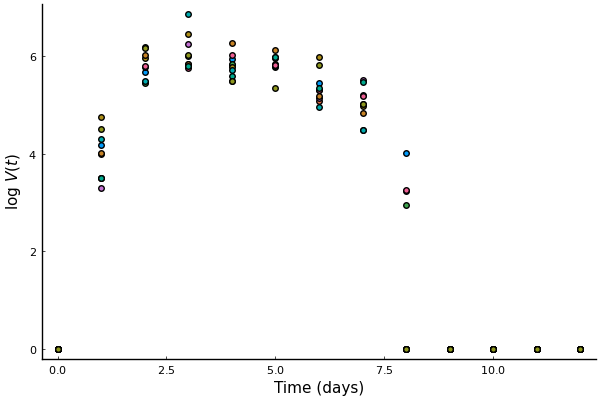

In [6]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

### Using combined data

In [7]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:]
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

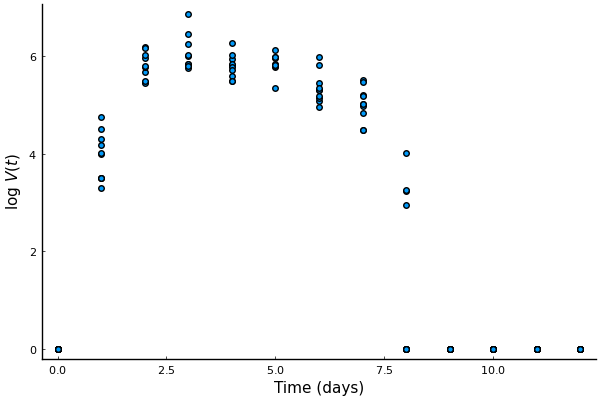

In [8]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

## 3. Optimizations methods

Two libraries: `LsqFit.jl` and `Optim.jl`.

### Levenberg-Marquardt via `LsqFit.jl`
It is particularly hard to choose initial values and lower and upper bounds

In [9]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit1 = @btime curve_fit((t, p) -> LogVirusLoad.(t, p...), ttdata, vvdata, par0, lower=lb, upper=ub)

  8.419 ms (57915 allocations: 1.27 MiB)


LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.7722333214929267, 3.1612139518627753, 6.3796823758428385, 7.726057611474353, 0.5032046701393494, 6.066867262152775], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true, Float64[])

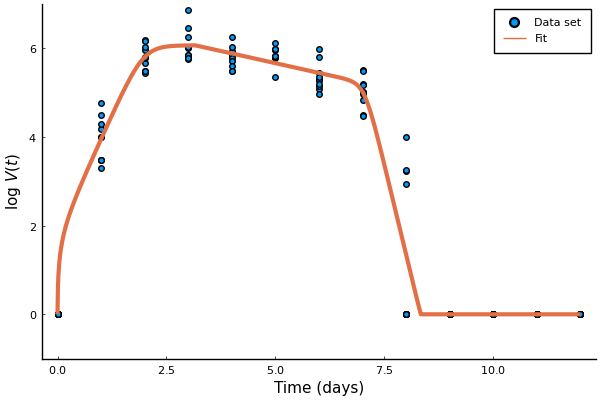

In [10]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.param...)
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    grid=:off, label="Fit",
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [11]:
println("RSS = ", sum(abs2, fit1.resid))
[println(p, " = ", v, ", CI=", ci) for (p, v, ci) in zip(par_names, fit1.param, confidence_interval(fit1))];

RSS = 35.26168626036801
a₁ = 0.7722333214929267, CI=(0.5426749263999647, 1.0017917165858887)
a₂ = 3.1612139518627753, CI=(2.4108408523036573, 3.9115870514218933)
b₁ = 6.3796823758428385, CI=(5.8448821977737575, 6.9144825539119195)
b₂ = 7.726057611474353, CI=(7.50876837051662, 7.943346852432086)
α = 0.5032046701393494, CI=(0.0827842635006169, 0.923625076778082)
logVmax = 6.066867262152775, CI=(5.817352960193171, 6.31638156411238)


### Box constrains with Conjugate Gradient via `Optim.jl` 
Let's use anothe numerical method different to Levenberg-Marquart. In this case, we use Simulated Annealing and Conjugate Gradient.

Convergence is faster and appears to be slightly better (smaller RSS) that with the previous method.

In [12]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.10, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit2 = @btime optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 51751

     Obj. value:     35.2616862604

       parameter      search width
         0.77223           0.00000 
         3.16121           0.00000 
         6.37968           0.00000 
         7.72606           0.00000 
         0.50320           0.00000 
         6.06687           0.00000 

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 52051

     Obj. value:     35.2616862604

       parameter      search width
         0.77223           0.00000 
         3.16121           0.00000 
         6.37968           0.00000 
         7.72606           0.00000 
         0.50320           0.00000 
         6.06687           0.00000 

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 52801

     Obj. value:     35.2616862604

       parameter      search width
         0.77223           0.00000 
         3.16121           0.

 * Status: failure

 * Candidate solution
    Final objective value:     3.526169e+01

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    51751
    f(x) calls:    51751
    ∇f(x) calls:   0


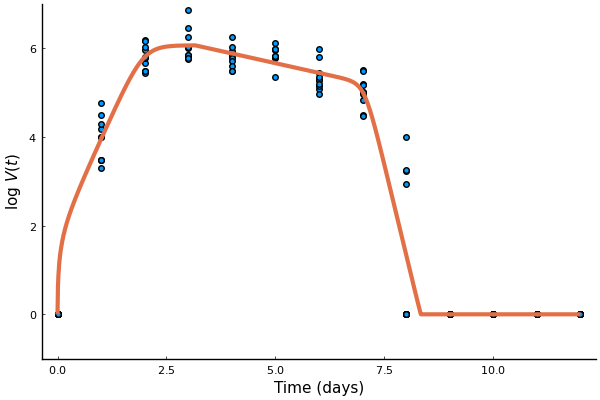

In [13]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit2.minimizer...)
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [14]:
println("RSS = ", fit2.minimum)
[println(p, " = ", n) for (p, n) in zip(par_names, fit2.minimizer)];

RSS = 35.26168626036818
a₁ = 0.7722333274581341
a₂ = 3.161213752532066
b₁ = 6.379682253868446
b₂ = 7.726057547623878
α = 0.5032045151075204
logVmax = 6.066867185847952


In [15]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit3 = @btime optimize(cost, lb, ub, par0, Fminbox(GradientDescent()))

  4.210 s (27132349 allocations: 579.98 MiB)


 * Status: success

 * Candidate solution
    Final objective value:     3.526169e+01

 * Found with
    Algorithm:     Fminbox with Gradient Descent

 * Convergence measures
    |x - x'|               = 4.77e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.92e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.45e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    10
    f(x) calls:    4553
    ∇f(x) calls:   4553


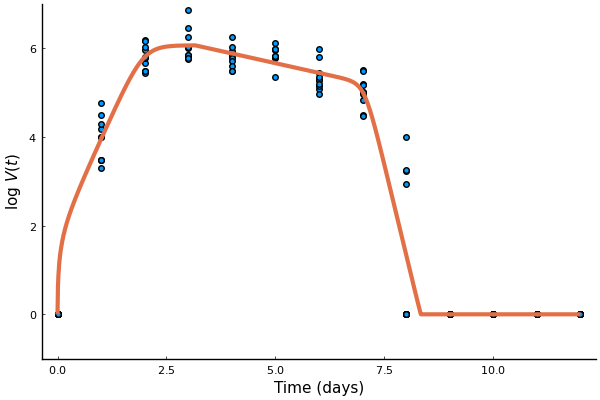

In [16]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit3.minimizer...)
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [17]:
println("RSS = ", fit3.minimum)
[println(p, " = ", n) for (p, n) in zip(par_names, fit3.minimizer)];

RSS = 35.26168626036804
a₁ = 0.7722333188866722
a₂ = 3.1612140591711553
b₁ = 6.379682447428849
b₂ = 7.726057645845268
α = 0.5032047398870904
logVmax = 6.066867287383039


Although all methods give the same results, it looks like `LsqFit.jl` is faster than `Optim.jl`, and that Simmulated Annealing is slightly faster than Conjugate Gradient with bounding box. Note that the `Optim.jl` package does not provide with standard error. They have to be computed separately.

## 4. Effect of trailling threshold values

All observation equal to zero (the threshold $\theta$ for this data set) represent any measurement below the threshold. Thus, increasing or decreasing the number of observations below the threshold should not affect the best fit. this time we'll remove the last three observations.

In [18]:
ttdata = repeat(tdata[1:end-3], inner=10)
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-3], 1, :)[:];
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

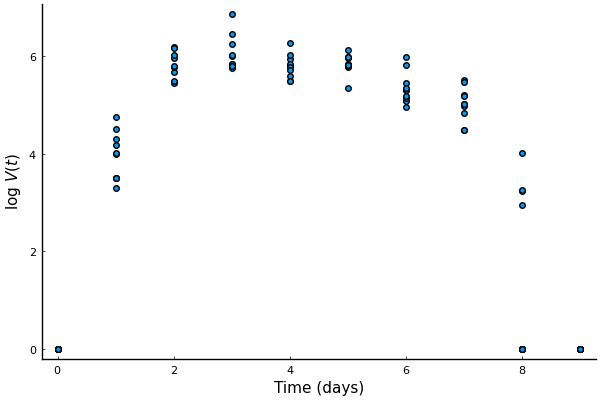

In [19]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xaxis=("Time (days)"), yaxis=(L"\log\,V(t)"))

Same initial conditions as in the first case

In [20]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit1 = @btime curve_fit((t, p) -> LogVirusLoad.(t, p...), ttdata, vvdata, par0, lower=lb, upper=ub)

  6.026 ms (46485 allocations: 1.03 MiB)


LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.7722333214848738, 3.1612139518855678, 6.37968237585077, 7.726057611477818, 0.5032046701465688, 6.066867262152907], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true, Float64[])

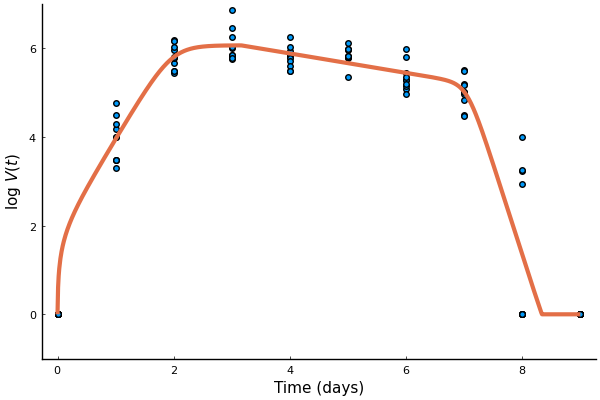

In [21]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.param...)
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [22]:
println("RSS = ", sum(abs2,fit1.resid))
[println(p, " = ", v, ", CI=", ci) for (p, v, ci) in zip(par_names, fit1.param, confidence_interval(fit1))];

RSS = 35.26168626036801
a₁ = 0.7722333214848738, CI=(0.507744176489958, 1.0367224664797896)
a₂ = 3.1612139518855678, CI=(2.296660340496157, 4.025767563274978)
b₁ = 6.37968237585077, CI=(5.763504336473976, 6.995860415227564)
b₂ = 7.726057611477818, CI=(7.475704556317182, 7.976410666638453)
α = 0.5032046701465688, CI=(0.01881099841312106, 0.9875983418800165)
logVmax = 6.066867262152907, CI=(5.779385620045433, 6.35434890426038)


This is the same best fit as before.
```
RSS = 35.26168626036801
a₁ = 0.7722333214929267, CI=(0.5426749263999647, 1.0017917165858887)
a₂ = 3.1612139518627753, CI=(2.4108408523036573, 3.9115870514218933)
b₁ = 6.3796823758428385, CI=(5.8448821977737575, 6.9144825539119195)
b₂ = 7.726057611474353, CI=(7.50876837051662, 7.943346852432086)
α = 0.5032046701393494, CI=(0.0827842635006169, 0.923625076778082)
logVmax = 6.066867262152775, CI=(5.817352960193171, 6.31638156411238)
```
Thus, repeated bellow the threshold do not have effect on estimates.

## 5. Changing the value of fixed $V_{min}$

Does the choice of $V_{min}$ effect the best fit? For this, we redefine the function and try different values $V_{min}=-4$, $-10$,  and $-14$.

In [23]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:]
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

RSS = 64.88375963805642
a₁ = 0.775496745105788, CI=(0.4537730023298811, 1.097220487881695)
a₂ = 3.265329915871244, CI=(2.467491448664548, 4.06316838307794)
b₁ = 5.0, CI=(4.139993105588285, 5.860006894411715)
b₂ = 8.202385150103629, CI=(7.9109184403619714, 8.493851859845286)
α = 0.6063559275322481, CI=(0.44873003551603463, 0.7639818195484616)
logVmax = 6.103121773692718, CI=(5.842643180349399, 6.363600367036036)


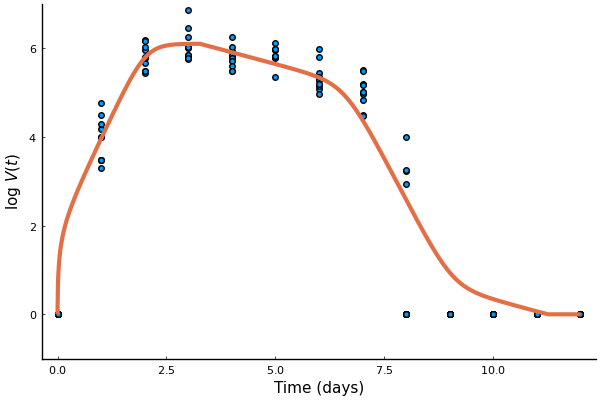

In [24]:
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -4.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit1 = curve_fit((t, p) -> LogVirusLoad.(t, p...), ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.param...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", sum(abs2,fit1.resid))
[println(p, " = ", v, ", CI=", ci) for (p, v, ci) in zip(par_names, fit1.param, confidence_interval(fit1))];
pt

RSS = 35.261685955885284
a₁ = 0.7722332963713423, CI=(0.5426749229946813, 1.0017916697480032)
a₂ = 3.161213640527254, CI=(2.41084009234737, 3.911587188707138)
b₁ = 6.379359905771512, CI=(5.843891669566535, 6.914828141976489)
b₂ = 7.7264344225240835, CI=(7.509670889654909, 7.943197955393258)
α = 0.503204242419045, CI=(0.08278318481688723, 0.9236253000212029)
logVmax = 6.066867135554626, CI=(5.817352724073452, 6.3163815470358005)


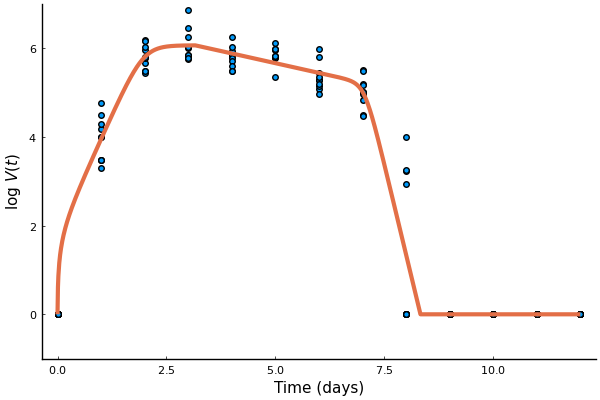

In [25]:
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -10.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit1 = curve_fit((t, p) -> LogVirusLoad.(t, p...), ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.param...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", sum(abs2,fit1.resid))
[println(p, " = ", v, ", CI=", ci) for (p, v, ci) in zip(par_names, fit1.param, confidence_interval(fit1))];
pt

RSS = 35.26168595585483
a₁ = 0.7722332963657695, CI=(0.5426749230073316, 1.0017916697242075)
a₂ = 3.1612136404518156, CI=(2.4108400921979936, 3.9115871887056377)
b₁ = 6.379359873550708, CI=(5.843891571143845, 6.914828175957571)
b₂ = 7.7264344601227295, CI=(7.50967097921717, 7.943197941028289)
α = 0.5032042423429302, CI=(0.08278318468120038, 0.9236253000046599)
logVmax = 6.066867135527433, CI=(5.817352724032454, 6.316381547022412)


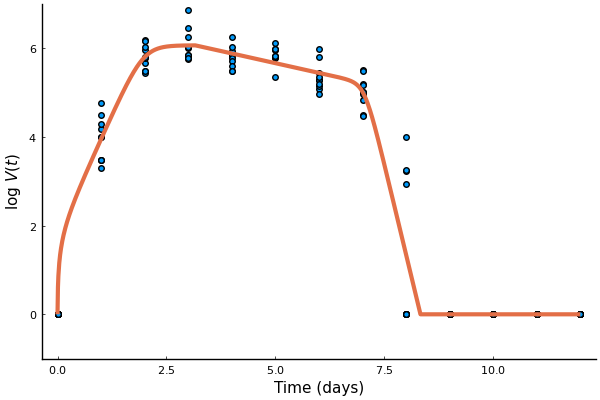

In [26]:
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -14.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit1 = curve_fit((t, p) -> LogVirusLoad.(t, p...), ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.param...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", sum(abs2,fit1.resid))
[println(p, " = ", v, ", CI=", ci) for (p, v, ci) in zip(par_names, fit1.param, confidence_interval(fit1))];
pt

Compare these results with the original best fit
```
RSS = 35.26168626036801
a₁ = 0.7722333214929267, CI=(0.5426749263999647, 1.0017917165858887)
a₂ = 3.1612139518627753, CI=(2.4108408523036573, 3.9115870514218933)
b₁ = 6.3796823758428385, CI=(5.8448821977737575, 6.9144825539119195)
b₂ = 7.726057611474353, CI=(7.50876837051662, 7.943346852432086)
α = 0.5032046701393494, CI=(0.0827842635006169, 0.923625076778082)
logVmax = 6.066867262152775, CI=(5.817352960193171, 6.31638156411238)
```
For $\log V_{min}=-4$ the fit is not good, but for $\log V_{min}<-6$ the fit is basically the same.

## 6. Empirical versus non-empirical Virus Load Function

Now let's use the virus load function without taking into account the threshold, that is without forcing the maximum value between the function and the threshold.

With all data points. The value of $\alpha$ is too small.

RSS = 39.99961978247489
a₁ = 0.9391976968341054, CI=(-6.395923123492582e8, 6.395923142276535e8)
a₂ = 1.334029697316707, CI=(-3.513729170026619e9, 3.5137291726946783e9)
b₁ = 6.097716435676327, CI=(5.865572938990526, 6.329859932362129)
b₂ = 7.480327241925353, CI=(7.398511836153551, 7.562142647697154)
α = 1.0e-8, CI=(-0.09015248115916094, 0.09015250115916093)
logVmax = 5.761459189667722, CI=(-9.343579788305497, 20.86649816764094)


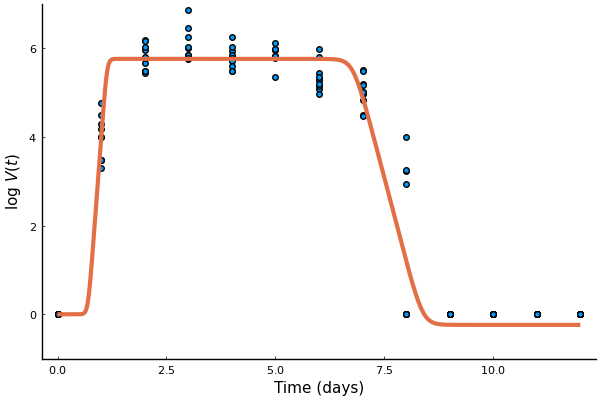

In [27]:
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    logVmin = -6.0
    log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit1 = curve_fit((t, p) -> LogVirusLoad.(t, p...), ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.param...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", sum(abs2,fit1.resid))
[println(p, " = ", v, ", CI=", ci) for (p, v, ci) in zip(par_names, fit1.param, confidence_interval(fit1))];
pt

It looks like the last threshold points do affect the fit. Now removing the last four observations. The result is the same as in the case of empirical virus load function.

RSS = 35.26168626036801
a₁ = 0.7722333214159117, CI=(0.4920084594214321, 1.0524581834103914)
a₂ = 3.161213952550182, CI=(2.2452239361146735, 4.077203968985691)
b₁ = 6.379682376202362, CI=(5.726844974579354, 7.032519777825369)
b₂ = 7.726057611638297, CI=(7.460809862380043, 7.991305360896551)
α = 0.5032046705021763, CI=(-0.010007884210058937, 1.0164172252144117)
logVmax = 6.066867262269016, CI=(5.762281970293168, 6.371452554244863)


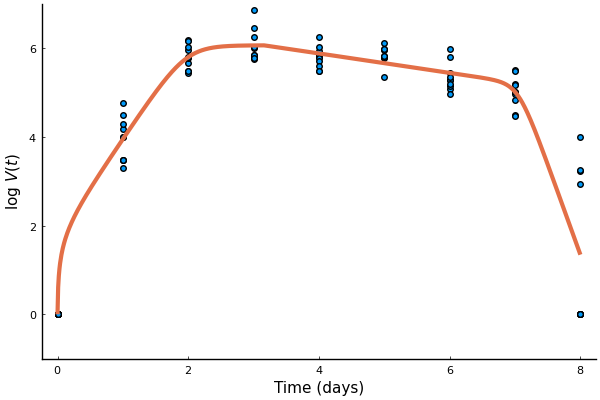

In [28]:
ttdata = repeat(tdata[1:end-4], inner=10)
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-4], 1, :)[:]
par0 = [0.70, 3.11, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit1 = curve_fit((t, p) -> LogVirusLoad.(t, p...), ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.param...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", sum(abs2,fit1.resid))
[println(p, " = ", v, ", CI=", ci) for (p, v, ci) in zip(par_names, fit1.param, confidence_interval(fit1))];
pt

**As we can see, the empirical virus load function is more adequate for data.**

**Conclusion: use full data set and empirical viral load function.**

## 7. Randomized initial estimate 

Choosing the initial parameter estimate was done manually in the previous sections, but this is impractical if we apply it to each of the individual subject. A good first guess is important in particular for local optimizers like Levenberg-Marquardt. Here we automate obtaining the initial guess using randomized initial guesses.

In [29]:
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -6.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
k = 1
ttdata = repeat(tdata[1:end], inner=1)
tend = ttdata[end]
vvdata = reshape(data[k, :], 1, :)[:]

13-element Vector{Float64}:
 0.0
 4.18551
 5.67816
 6.00515
 5.9364
 5.97712
 5.44716
 5.19848
 4.00515
 0.0
 0.0
 0.0
 0.0

RSS = 0.06362559352871518
a₁ = 0.5449957041293786, CI=(0.293179855860632, 0.7968115523981252)
a₂ = 3.758939784675917, CI=(3.248387951706038, 4.269491617645796)
b₁ = 7.074896001488178, CI=(6.942195828390298, 7.207596174586059)
b₂ = 8.440451865704905, CI=(8.310287656643762, 8.570616074766047)
α = 0.6001417360524332, CI=(0.3852392723537766, 0.8150441997510898)
logVmax = 6.084163130255778, CI=(5.938881905060145, 6.2294443554514105)


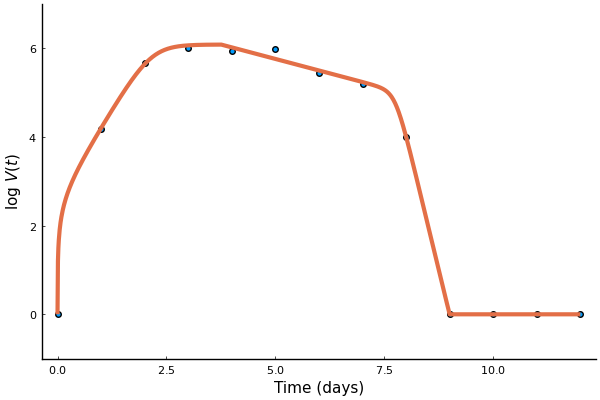

In [30]:
niter = 10
bestfit = nothing
for iter = 1:niter
    #       a₁,   a₂,   b₁,   b₂,           α,    logVmax
    par0 = vcat(sort(ttdata[end]*rand(4)), [0.80, maximum(vvdata)])
    lb   = vcat(0, (par0[1:3]+par0[2:4])/2, 1e-8, max(par0[6] - 4, 1))
    ub   = vcat((par0[1:3]+par0[2:4])/2, tend, 10.0, par0[6] + 4)
    fit1 = curve_fit((t, p) -> LogVirusLoad.(t, p...), ttdata, vvdata, par0, lower=lb, upper=ub)
    if bestfit == nothing
        bestfit = fit1
    else
        if sum(abs2, fit1.resid) < sum(abs2, bestfit.resid)
            bestfit = fit1
        end
    end
end
fit1 = bestfit
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.param...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", sum(abs2,fit1.resid))
[println(p, " = ", v, ", CI=", ci) for (p, v, ci) in zip(par_names, fit1.param, confidence_interval(fit1))];
pt

One issue is that sometimes there are singularity exceptions coming from the linear algebra package.

Alternatively, Simmulated Annealling is global.

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 69601

     Obj. value:      0.0636641880

       parameter      search width
         0.54497           0.00000 
         3.75921           0.00000 
         8.36001           0.00000 
         7.24433           0.00000 
         0.60049           0.00000 
         6.08422           0.00000 

RSS = 0.0636641879702736
a₁ = 0.5449696568365922
a₂ = 3.759208378592944
b₁ = 8.360005744990271
b₂ = 7.244330184773522
α = 0.6004879991841973
logVmax = 6.084217592200978


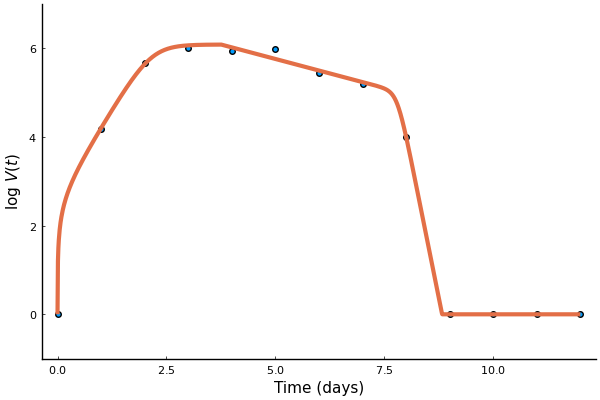

In [31]:
par0 = vcat(sort(ttdata[end]*rand(4)), [0.80, maximum(vvdata)])
lb   = [0.0, 0.0, 0.0, 0.0, 1e-8, par0[6] - 4]
ub   = [tend, tend, tend, tend, 10.0, par0[6] + 4]
fit2 = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^6))
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit2.minimizer...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", fit2.minimum)
[println(p, " = ", v) for (p, v) in zip(par_names, fit2.minimizer)];
pt


Same results for much less trouble. The only problem is to assert that the best estimate satisfies the best ordering condition.

## Figures for the papers and presentations

In [4]:
Plots.scalefontsizes(1/1.4)

In [5]:
H(x) = 0.5*(tanh(1e3*x) + 1.)
function v₁(t, a₁, a₂, logVmax)
    1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/abs(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/abs(a₂ - a₁)))/2
end
function v₂(t, a₂, α) 
    1. - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
end
function v₃(t, b₁, b₂, logVmin)
    1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/abs(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/abs(b₂ - b₁)))/2
end
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    logVmin = -6.0
    log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
end
tend = 25.
par = [0.5,
       4.0,
       13.0,
       19.0,
       0.1,
       5.0]
tt = Vector(range(0., tend, step=1e-2))
vv = LogVirusLoad.(tt, par...)
vv1 = v₁.(tt, par[1], par[2], par[6])
vv2 = v₂.(tt, par[2], par[5])
vv3 = v₃.(tt, par[3], par[4], -6.0);

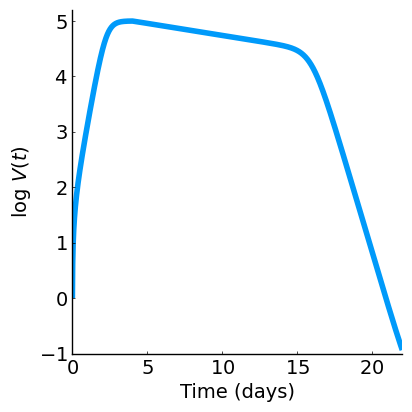

In [10]:
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)))
savefig("figures/VirusLoadLog2.pdf")

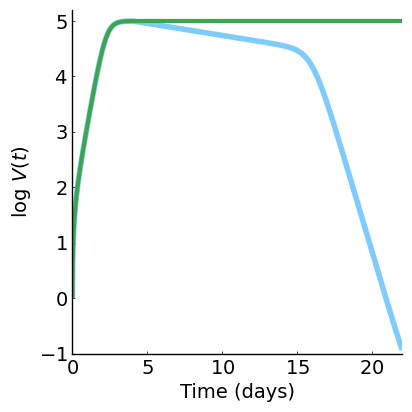

In [8]:
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)), alpha=0.5)
plot!(tt, log10.(vv1), lw=3, color=3)
savefig("figures/VirusLoadLog3.pdf")

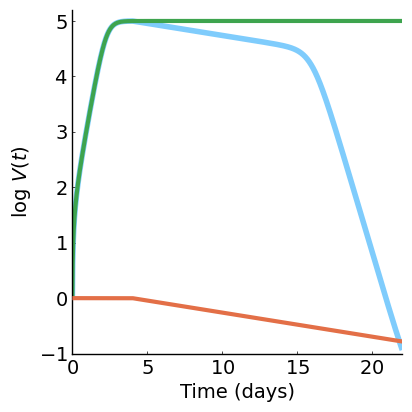

In [9]:
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)), alpha=0.5)
plot!(tt, log10.(vv1), lw=3, color=3)
plot!(tt, log10.(vv2), lw=3, color=2)
savefig("figures/VirusLoadLog4.pdf")

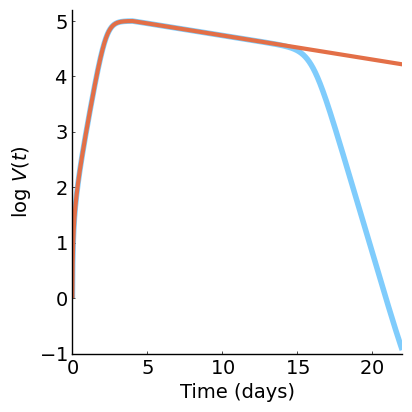

In [12]:
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)), alpha=0.5)
plot!(tt, log10.(vv1.*vv2), lw=3, color=2)
savefig("figures/VirusLoadLog5.pdf")

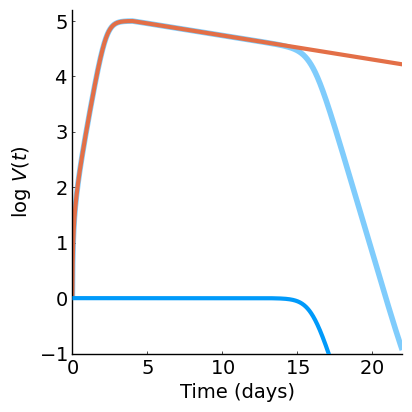

In [13]:
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)), alpha=0.5)
# plot!(tt, log10.(vv1), lw=3, color=2)
# plot!(tt, log10.(vv2), lw=3, color=3, alpha=0.5)
plot!(tt, log10.(vv1.*vv2), lw=3, color=2)
plot!(tt, log10.(vv3), lw=3, color=1)
savefig("figures/VirusLoadLog6.pdf")

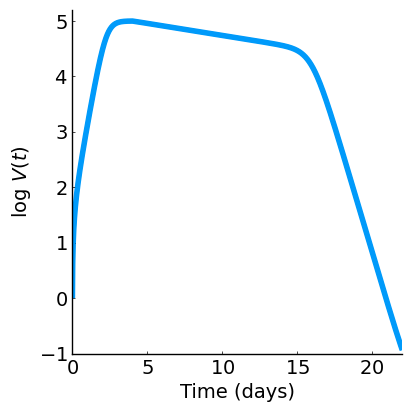

In [14]:
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)))
plot!(tt, log10.(vv1.*vv2.*vv3), lw=3, color=1)
# plot!(tt, log10.(vv3), lw=3, color=1, alpha=0.5)
savefig("figures/VirusLoadLog7.pdf")

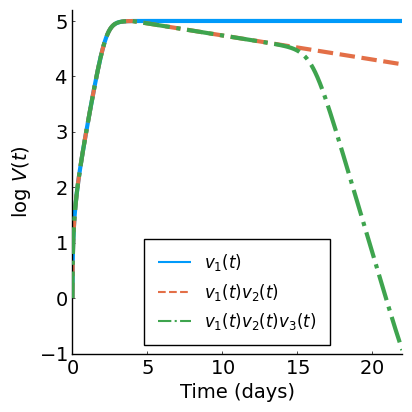

In [15]:
pt = plot(grid=:off, size=(400, 400), 
    legend=:bottom, legendfontsize=12,
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)))
plot!(tt, log10.(vv1), line=(3, :solid), color=1, label=L"v_1(t)")
plot!(tt, log10.(vv1.*vv2), line=(3, :dash), color=2, alpha=1, label=L"v_1(t)v_2(t)")
plot!(tt, log10.(vv1.*vv2.*vv3), line=(3, :dashdot), color=3, alpha=1, label=L"v_1(t)v_2(t)v_3(t)")
# legend!()
savefig("figures/VirusLoadLog8.pdf")

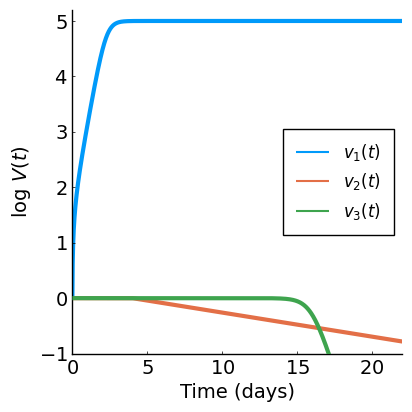

In [16]:
pt = plot(grid=:off, size=(400, 400), 
    legend=:right, legendfontsize=12,
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)))
plot!(tt, log10.(vv1), line=(3, :solid), color=1, label=L"v_1(t)")
plot!(tt, log10.(vv2), line=(3, :solid), color=2, alpha=1, label=L"v_2(t)")
plot!(tt, log10.(vv3), line=(3, :solid), color=3, alpha=1, label=L"v_3(t)")
# legend!()
savefig("figures/VirusLoadLog9.pdf")

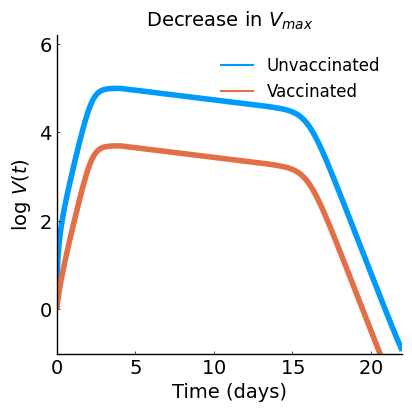

In [111]:
tt = Vector(range(0., tend, step=1e-2))
vv1 = LogVirusLoad.(tt, [0.5, 4.0, 13.0, 19.0, 0.1, 5.0]...)
vv2 = LogVirusLoad.(tt, [0.5, 4.0, 13.0, 19.0, 0.1, 3.7]...)

pt1 = plot(tt, vv1, lw=4, label="Unvaccinated",
    grid=:off, size=(400, 400),
    xaxis=("Time (days)", (0., 22.), font(14)),
    yaxis=(L"$\log\, V(t)$", (-1, 6.2), font(14)),
    legend=:topright, legendfontsize=12, bg_legend=:transparent, 
    title=L"Decrease in $V_{max}$", titlefontsize=14)
plot!(pt1, tt, vv2, lw=4, label="Vaccinated")
savefig("figures/VirusLoadLogvaccine1.pdf")
savefig("figures/VirusLoadLogvaccine1.png")

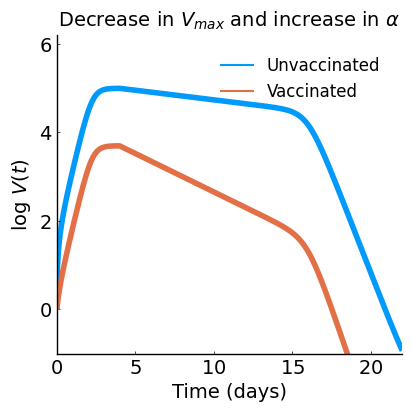

In [109]:
tt = Vector(range(0., tend, step=1e-2))
vv1 = LogVirusLoad.(tt, [0.5, 4.0, 13.0, 19.0, 0.1, 5.0]...)
vv2 = LogVirusLoad.(tt, [0.5, 4.0, 13.0, 19.0, 0.4, 3.7]...)

pt1 = plot(tt, vv1, lw=4, label="Unvaccinated",
    grid=:off, size=(400, 400),
    xaxis=("Time (days)", (0., 22.), font(14)),
    yaxis=(L"$\log\, V(t)$", (-1, 6.2), font(14)),
    legend=:topright, legendfontsize=12, bg_legend=:transparent, 
    title=L"Decrease in $V_{max}$ and increase in $\alpha$", titlefontsize=14)
plot!(pt1, tt, vv2, lw=4, label="Vaccinated")
savefig("figures/VirusLoadLogvaccine2.pdf")
savefig("figures/VirusLoadLogvaccine2.png")

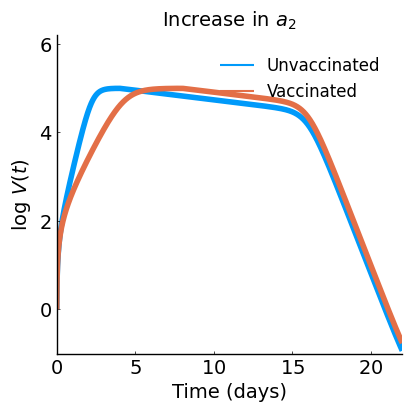

In [112]:
tt = Vector(range(0., tend, step=1e-2))
vv1 = LogVirusLoad.(tt, [0.5, 4.0, 13.0, 19.0, 0.1, 5.0]...)
vv2 = LogVirusLoad.(tt, [0.5, 8.0, 13.0, 19.0, 0.1, 5.0]...)

pt1 = plot(tt, vv1, lw=4, label="Unvaccinated",
    grid=:off, size=(400, 400),
    xaxis=("Time (days)", (0., 22.), font(14)),
    yaxis=(L"$\log\, V(t)$", (-1, 6.2), font(14)),
    legend=:topright, legendfontsize=12, bg_legend=:transparent, 
    title=L"Increase in $a_2$", titlefontsize=14)
plot!(pt1, tt, vv2, lw=4, label="Vaccinated")
savefig("figures/VirusLoadLogvaccine3.pdf")
savefig("figures/VirusLoadLogvaccine3.png")